### Recurrent Neural Network(RNN)
1. 순환 신경망은 기존에 공부해오던 네트워크와는 조금 차이가 존재한다.
  - 순환 신경망은 순서가 있는 데이터를 입력으로 받고, 같은 네트워크를 이용해서 변화하는 입력에 대한 출력을 얻어낸다.
2. 순서가 있는 데이터의 예로는 음악, 자연어, 날씨, 주가 등이 존재하는데, 이 변화가 의미가 있어야만 학습과 예측이 가능하다.

#### 7.1 순환 신경망의 구조

1. 입력이 X1, X2, X3로 변할 떄에 같은 네트워크를 사용해서 출력인 Y1, Y2, Y3를 반환한다. 중요한 것은 출력값이 다음 입력을 받을 때의 RNN 네트워크에도 동일하게 전달한다는 것이다. 
2. 처음에는 입력 X1을 받고, 그 다음에는 X2와 이전 단계의 출력인 Y1, 그 다음에는 X3과 이전 단계의 출력인 Y2를 입력으로 받는다.
3. 이 과정에서 순환신경망 네트워크는 동일하게 적용이 된다.

- 순환 신경망은 입력과 출력의 길이에 제한이 없기 때문에 다양한 형태의 네트워크를 만드는 것이 가능한데, 그렇기 때문에 이미지 설명 생성, 문장의 감정 분석, 기계 번역 등의 다양한 용도로 순환 신경망이 사용이 가능하다.

#### 7.2 주요 레이어 정리
- 순환 신경망의 가장 기초적인 layer은 SimpleRNN layer이다.
- 이외에도 LSTM, GRU, Embedding layer이 존재한다.

**7.2.1 SImple Rnn Layer**
- t번째 단계에서 Simple RNN layer의 출력에 대해 알아보자.
- t번째 output = tanh(입력에 곱해지는 가중치 + 출력에 곱해지는 가중치 * (t-1)번째 output)
  - 여기서 알 수 있겠지만 활성화 함수로는 tanh가 사용되고, tanh함수는 실수 입력을 받아 -1에서 1 사이의 출력값을 반환하는 함수이다.
  - 활성화 함수의 자리로는 ReLU도 사용이 가능하다.

```
rnn = tf.keras.layers.SimpleRNN(units = 1, activation = 'tanh', return_sequences = True)
```
1. units = SimpleRNN layer에 존재하는 뉴런의 수
2. return_sequence = 출력으로 시퀀스 전체를 출력할지 말지의 여부를 나타내는 옵션으로, 여러개의 RNN 레이어를 쌓아야 할 때 쓰인다.

간단한 예시를 이용해서 Simple RNN Layer을 학습해 보자

In [1]:
x,y = [],[]
for i in range(6):
  #6개의 4개로 이루어진 sequence 데이터 만들기
  file = list(range(i, i+4))
  #Simple RNN에 각 타임 스텝에 하나씩 숫자가 들어가기 때문에 하나씩 분리해서 배열에 저장한다.
  x.append(list(map(lambda data: [data/10], file)))
  y.append((i+4)/10)

In [3]:
for i in range(len(x)):
  print(x[i], y[i])

[[0.0], [0.1], [0.2], [0.3]] 0.4
[[0.1], [0.2], [0.3], [0.4]] 0.5
[[0.2], [0.3], [0.4], [0.5]] 0.6
[[0.3], [0.4], [0.5], [0.6]] 0.7
[[0.4], [0.5], [0.6], [0.7]] 0.8
[[0.5], [0.6], [0.7], [0.8]] 0.9


- input_shape = (timesteps, input_dim)
  - timesteps = 순환 신경망이 입력에 의해서 계싼을 반복하는 횟수
  - input_dim = 입력 벡터의 크기

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd

x,y = np.array(x), np.array(y)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(units = 10, return_sequences = False, input_shape = [4,1]))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(x,y,epochs = 100, verbose = 0)
#verbose는 진행 과정 출력 여부를 묻는다. 0으로 설정하면 아무 값도 나오지 않음

In [9]:
print(model.predict(x))

[[0.37938747]
 [0.5320921 ]
 [0.6517059 ]
 [0.7362555 ]
 [0.7917047 ]
 [0.82610714]]


In [12]:
model.predict(np.array([[[-0.2],[-0.1],[0.0],[0.1]]]))

array([[0.03654714]], dtype=float32)

- 신경망에 일반화된 규칙을 학습시키는 것은 여전히 어려운 과제중에 하나이다.
- 이제 SimpleRNN의 단점을 개선한 다른 Layer에 대해서 알아보자.

**7.2.2 LSTM Layer**
- SimpleRNN layer의 가장 큰 문제점은 입력 데이터가 길어질 수록, 즉 timestep이 커질 수록 학습 능력이 떨어진다는 점이다. 
- 이를 장기 의존성 문제라고 하는데, 현재의 결과를 위해 과거의 데이터를 이용해야 하는 RNN의 경우에는 과거 시점이 현재와 너무 멀어져 버리면 학습이 힘들다.

- SImpleRNN cell에서는 타임스텝의 발향으로 출력값만이 전달되는 반면 LSTM cell에서는 셀 상태가 평행선을 그리며 함께 전달이 된다.
- 타임 스텝을 가로지르며 셀의 상태가 보존이 되기 때문에 장기 의존성 문제를 해결할 것이라고 본다.

- 수식들을 정리해 보자면 
  1. Input = sigmoid(input*입력층 입력 가중치 + 이전 출력*입력층 출력 가중치)
  2. Forget = sigmoid(input*forget층 입력 가중치 + 이전 출력 * forget층 출력 가중치)
  3. Output = sigmoid(input*출력층 입력 가중치 + 이전 출력 * 출력층 출력 가중치)
  4. 셀 상태가 되기 전 출력 = tanh(입력*입력 가중치 + 출력*출력 가중치)
  5. 셀 상태의 출력 = (Forget * 이전 셀 출력 + Input * 셀 상태가 되기 전 출력)
    - 여기서 Forget값을 곱함으로서 이전 타임스텝의 셀의 상태를 얼마나 남길지 결정하게 된다.
  6. FInal = tanh(셀상태의 출력)*Output

- 따라서 LSTM의 출력은 현재 스텝에서 계산된 셀의 상태에 tanh활성화 함수를 취한 값을 Output 게이트의 출력에 곱한 값이다.

In [13]:
#LSTM을 시험해 보기 위해서 '곱셈 문제(Multiplication Problem)'을 풀어볼 예정이다.
#이 문제는 실수에 곱셈을 하#LSTM을 시험해 보기 위해서 '곱셈 문제(Multiplication Problem)'을 풀어볼 예정이다.
#이 문제는 실수에 곱셈을 하는 문제인데, 고려해야 할 실수의 범위가 100개이고 그중 마킹된 두 개의 숫자만 곱해야 한다.
#우선 두개의 수가 마킹이 된 데이터를 생성해야 한다

In [16]:
x,y = [],[]
for i in range(3000):
  #랜덤한 숫자 100개
  file = np.random.rand(100)
  #그중 2개의 수 선택
  index = np.random.choice(100, 2, replace = False)
  #원-핫 인코딩 벡터 만들기
  zeros = np.zeros(100)
  zeros[index] += 1
  #마킹한 수와 전체 수를 합쳐서 데이터셋 만들기
  x.append(np.array(list(zip(zeros, file))))
  #인덱싱할 2개의 숫자를 곱한 값이 우리가 예측해야 할 값이므로 y리스트에 넣어주기
  y.append(np.prod(file[index]))

In [ ]:
print(x[0], y[0])

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

In [27]:
#1. Simple RNN이용해서 모델 만들기
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.SimpleRNN(units = 30, input_shape = [100,2], return_sequences = True))
#여기서 return_sequences = True로 설정한 이유는 RNN layer을 겹쳐서 사용하기 위해서이다.
model1.add(tf.keras.layers.SimpleRNN(units = 30))
model1.add(tf.keras.layers.Dense(1))

model1.compile(optimizer = 'adam', loss = 'mse')
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 100, 30)           990       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 2,851
Trainable params: 2,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
#2. LSTM 이용해서 모델 만들기
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.LSTM(units = 30, return_sequences=True, input_shape = [100,2]))
model2.add(tf.keras.layers.LSTM(units = 30))
model2.add(tf.keras.layers.Dense(1))

model2.compile(optimizer = 'adam', loss = 'mse')
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 30)           3960      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 11,311
Trainable params: 11,311
Non-trainable params: 0
_________________________________________________________________


In [34]:
hist1 = model1.fit(x_train, y_train, validation_data = (x_val, y_val), verbose = 0, epochs = 30)

In [35]:
hist2 = model2.fit(x_train, y_train,validation_data = (x_val, y_val), verbose = 0, epochs = 30)

In [36]:
print(model1.evaluate(x_test, y_test), model2.evaluate(x_test, y_test))
#여기서 loss가 출력된 이유는 metrics = ['accuracy']라고 설정하지 않았기 때문이다.

19/19 [==============================] - 0s 16ms/step - loss: 0.0016
0.08099894225597382 0.0016092569567263126


In [40]:
def calc_loss(pred, target):
  fail = 0
  for i in range(len(pred)):
    if abs(pred[i]-target[i]) > 0.04:
      fail += 1
  return ('Accuracy:{}%'.format((600-fail)/600 *100))

In [41]:
print('Simple RNN:{} | LSTM:{}'.format(calc_loss(model1.predict(x_test), y_test), calc_loss(model2.predict(x_test), y_test)))

Simple RNN:Accuracy:10.0% | LSTM:Accuracy:76.66666666666667%


확실히 LSTM layer의 정확도가 훨씬 높음을 확인할 수 있다.

**7.2.3 GRU Layer**

- 전반적으로 LSTM layer과 비슷하지만, 셀의 상태가 보이지 않는다는 차이를 보인다.
- 또한, LSTM layer에 비해서 sigmoid 함수가 하나 적게 쓰였는데, 이는 게이트의 수가 하나 줄었음을 의미한다.

- 수식을 살펴보자
  1. Update = sigmoid(입력*update층 입력 가중치 + 이전 출력 * update층 출력 가중치)
  2. Reset = sigmoid(입력*reset층 입력 가중치 + 이전 출력*reset층 출력 가중치)
  3. 최종 출력 전 셀의 출력 = tanh(입력 * 셀 입력 가중치 + 이전 출력*reset층 출력값 * 셀 출력 가중치)
  4. 최종 출력 = (1-update층 출력)*이전 셀 출력 + update층 출력 * 최종 전 셀 출력
    - GRU의 Update layer은 LSTM의 Input과 Forget 게이트의 출력의 역할을 동시에 수행한다.
    - 이미 Update layer의 출력값에 따라서 어느 정도의 비율을 점유할지 이전스텝의 출력에서 결정이 되기 떄문이다.
    - Reset 게이트는 이전 타임스텝의 정보를 얼마나 저장할지를 결정짓는 역할을 한다.

In [47]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.GRU(units = 30, input_shape = [100,2], return_sequences=True))
model3.add(tf.keras.layers.GRU(units = 30))
model3.add(tf.keras.layers.Dense(1))

model3.summary()
model3.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])
hist3 = model3.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 30, verbose = 0)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 100, 30)           3060      
_________________________________________________________________
gru_8 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 8,671
Trainable params: 8,671
Non-trainable params: 0
_________________________________________________________________


In [48]:
model3.evaluate(x_test, y_test)
print(calc_loss(model3.predict(x_test),y_test))

19/19 [==============================] - 0s 16ms/step - loss: 9.5127e-04 - accuracy: 0.0000e+00
Accuracy:84.5%


In [56]:
hist3.history

{'accuracy': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'loss': [0.05705660209059715,
  0.05277293175458908,
  0.0528525672852993,
  0.05317047983407974,
  0.05234915763139725,
  0.05265417322516441,
  0.052177250385284424,
  0.05214689299464226,
  0.0521852932870388,
  0.052287474274635315,
  0.05245445668697357,
  0.05220954492688179,
  0.051745034754276276,
  0.05181127414107323,
  0.051758214831352234,
  0.05148812010884285,
  0.051244787871837616,
  0.05121118575334549,
  0.05112224817276001,
  0.05062694847583771,
  0.049880556762218475,
  0.0489056222140789,
  0.03730354458093643,
  0.006827234756201506,
  0.002754663582891226,
  0.002116205869242549,
  0.0014683777699247003,
  0.0017555566737428308,
  0.0012040416477248073,
  0.0014250022359192371],
 'val_accuracy': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

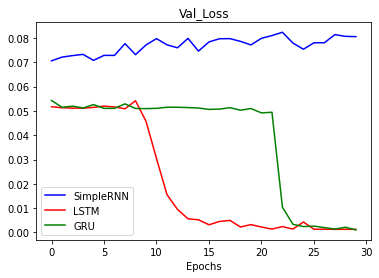

In [55]:
import matplotlib.pyplot as plt
plt.plot(figsize = (20,20))
plt.plot(hist1.history['val_loss'], 'b-', label = 'SimpleRNN')
plt.plot(hist2.history['val_loss'], 'r-', label = 'LSTM')
plt.plot(hist3.history['val_loss'], 'g-', label = 'GRU')
plt.title('Val_Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

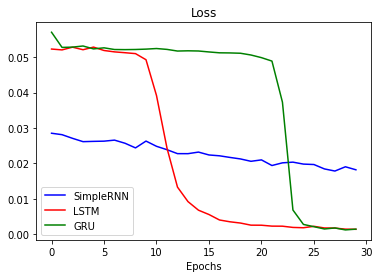

In [57]:
import matplotlib.pyplot as plt
plt.plot(figsize = (20,20))
plt.plot(hist1.history['loss'], 'b-', label = 'SimpleRNN')
plt.plot(hist2.history['loss'], 'r-', label = 'LSTM')
plt.plot(hist3.history['loss'], 'g-', label = 'GRU')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### GRU 보다 LSTM이 조금 더 나은 결과를 보이는데, 일반적으로는 GRU가 더 나은 결과를 보이기는 해야 한다. 

**7.2.4 Embedding Layer**

- Embedding Layer은 자연어를 수치화된 정보로 바꾸기 위한 데이터이다.
- 자연어는 시간의 흐름에 따라 정보가 연속적으로 쪼개어지는 것이 가능한 squence data이다. 
- 이미지를 픽셀 단위로 잘게 쪼갤 수 있듯이 자연어도 정보를 잘게 쪼갤 수 있는데, 영어는 문자, 한글은 자소 단위까지 쪼개는 것이 가능하다.

- 임베딩 레이어보다 좀 더 쉬운 기법은 자연어를 구성하는 단위에 대해 정수 인덱스를 저장하는 방법이 존재한다. 예를 들어 보자.
  1. 'This is a grey cat.'라는 문장이 있다고 하자.
  2. 이 문장에 대해 정수 인덱스를 저장하면 [0,1,2,3,4]가 된다. 
  3. 한편, 이 때 'This is grey'라는 문장은 [0,1,3]이라는 데이터로 바뀌는 것이 가능하다.
  4. 학습을 위해 신경망에 넣을 데이터로 변환할 때는 원-핫 인코딩을 통해서 해당 원소만 1로 저장하고 나머지는 0으로 바꾸는 것이 가능하다.
    - 이때 원-핫 인코딩 배열의 두번째 차원의 크기는 단어의 수와 같다.
    - 그렇기 때문에 원-핫 인코딩은 메모리에 비해 너무 적은 정보량을 저장한다.
    - 이에 비해 **임베딩 레이어는 한정된 길이의 벡터로 자연어의 구성 단위인 자소, 문자, 단어, n-gram등을 표현**할 수 있다.

|단어|정수 인덱스|원-핫 인코딩|임베딩 레이어|단어 임베딩|
|---|:---:|:---:|:---:|:---|
|this|0|[1,0,0,...0]|[0.2,0.4,0.4,0.0,0.0.....]|[0.1,0.4,0.4,0.4,0.0.0,1...]
||||[0.2,0.1,0.0,0.0,0.1,...]|

- 이런 식으로 진행이 되는데, 총 샘플 단어로서 존재했던 단어의 개수를 n이라 할때 원-핫인코딩은 각 단어마다 길이 n인 형태로 바뀌고, 임베딩 레이어는 m으로 임베딩 차원수를 지정해 주면 단어의 개수만큼, 길이가 m인 배열이 생성이된다.

- 따라서 임베딩 레이어는 정수 인덱스에 저장된 단어의 수 만큼 단어 임베딩을 가지고 있다가 필요할 떄 꺼내 쓸 수 있는 저장 공간이다.
  - 주의해야 하는 것은 자연어에는 우리가 준비하지 못한 단어들이 존재할 수 있기에 그 단어를 위한 padding이라는 자리를 마련해 주어야 힌디는 것이다.
  - 임베딩 레이어를 학습시키는 방법으로는 Word2Vec, GloVe, FastText, ELMo등 다양하고 이 방법을 이용하면 미리 훈련된 임베딩 레이어의 가중치를 가져와서 학습 시간 절약이 가능하다.(Tensorflow Hub에서 불러오기 가능) 
    - 하지만 개념을 익히기 위해 랜덤한 값애서 시작해서 가중치를 점점 적합한 값으로 학습시키는 방법으로 임베딩 레이어를 앞으로의 사례에 사용해 보고자 한다.